# Univariate calibration with SCE-UA
***

**Autor:** Chus Casado<br>
**Date:** 09-11-2023<br>

**Introduction:**<br>
In this code I calibrate the LISFLOOD routine in 94 reservoirs in the US for which we have both the GloFASv4 simulation and the records from ResOpsUS. 

The calibration looks for the optimal value of 6 parameters that control the normal state of the reservoir ($FF_n$, $\alpha$, $QQ_n$), the flood state ($FF_f$, $QQ_f$), and the factor that limits the outflow depending on the inflow ($\beta$). $FF$ stands for fracion filled, i.e., the proportion of the reservoir that is filled. $QQ$ stands for outflow quantile. The algorithm used to seach for the optimal parameters is SCE-UA (Shuffle Complex Evolution University of Arizona) [(Duan et al., 1994)](https://www.sciencedirect.com/science/article/abs/pii/0022169494900574), and the target variable is the observed outflow.

**To do:**<br>
* [ ] Clean observed time series

**Questions:**<br>
* [ ] Why only some of the iterations are saved in the CSV file?
* [ ] What's the relation between likelihood and KGE?
* [ ] Fit the $Q_{min}$ based on the inflow data. Hot to fit a GEV to minima.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import spotpy
from spotpy.objectivefunctions import kge
import yaml
from pathlib import Path
from tqdm.notebook import tqdm
import glob
# import cartopy.crs as ccrs
# import cartopy.feature as cf

In [2]:
from calibration.bivariate_lisflood import bivariate_6pars_1of
from reservoirs import Lisflood
from metrics import KGEmod, pareto_front
from plots import plot_iterations

## Configuration

In [3]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

### Paths

In [4]:
path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

# results will be saved in this path
path_out = Path('../results/reservoirs/LISFLOOD/calibration/SCEUA/6parameters/bivariate/')
path_out.mkdir(parents=True, exist_ok=True)

### Calibration

In [5]:
# # sequential mode
# parallel = "seq"  

# SCEUA parameters
max_iter = 1000
complexes = 4
train_size = .7

## Data

### GloFAS

#### Reservoirs

In [6]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../GIS/reservoirs_analysis_US.shp')
reservoirs.set_index('ResID', drop=True, inplace=True)

print(f'{reservoirs.shape[0]} reservoirs in the shape file')

94 reservoirs in the shape file


#### Time series

In [7]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs in the GloFAS time series')

# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

# period of GloFAS simulation
start, end = glofas_ts[id].first_valid_index(), glofas_ts[id].last_valid_index()

  0%|          | 0/143 [00:00<?, ?it/s]

94 reservoirs in the GloFAS time series


### ResOpsUS
#### Time series

In [8]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

print(f'{len(resops_ts)} reservoirs in the ResOpsUS time series')
    
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

  0%|          | 0/94 [00:00<?, ?it/s]

94 reservoirs in the ResOpsUS time series


## Calibration

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  1000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file '..\results\reservoirs\LISFLOOD\calibration\SCEUA\6parameters\bivariate/275_samples.csv' created.
4 of 1000, minimal objective function=1.93246, time remaining: 00:08:13
8 of 1000, minimal objective function=1.11174, time remaining: 00:09:07
12 of 1000, minimal objective function=0.737618, time remaining: 00:09:37
16 of 1000, minimal objective function=0.737618, time remaining: 00:09:57
19 of 1000, minimal objective function=0.737618, time remaining: 00:10:08
23 of 1000, minimal objective function=0.737618, time remaining: 00:10:08
27 of 1000, minimal objective function=0.737618, time remaining: 00:10:11
30 of 1000, minimal objective function=0.737618, time remaining: 00:10:15
33 of 1000, minimal objective function=0.737618, time remaining: 0

  0%|          | 0/408 [00:00<?, ?it/s]

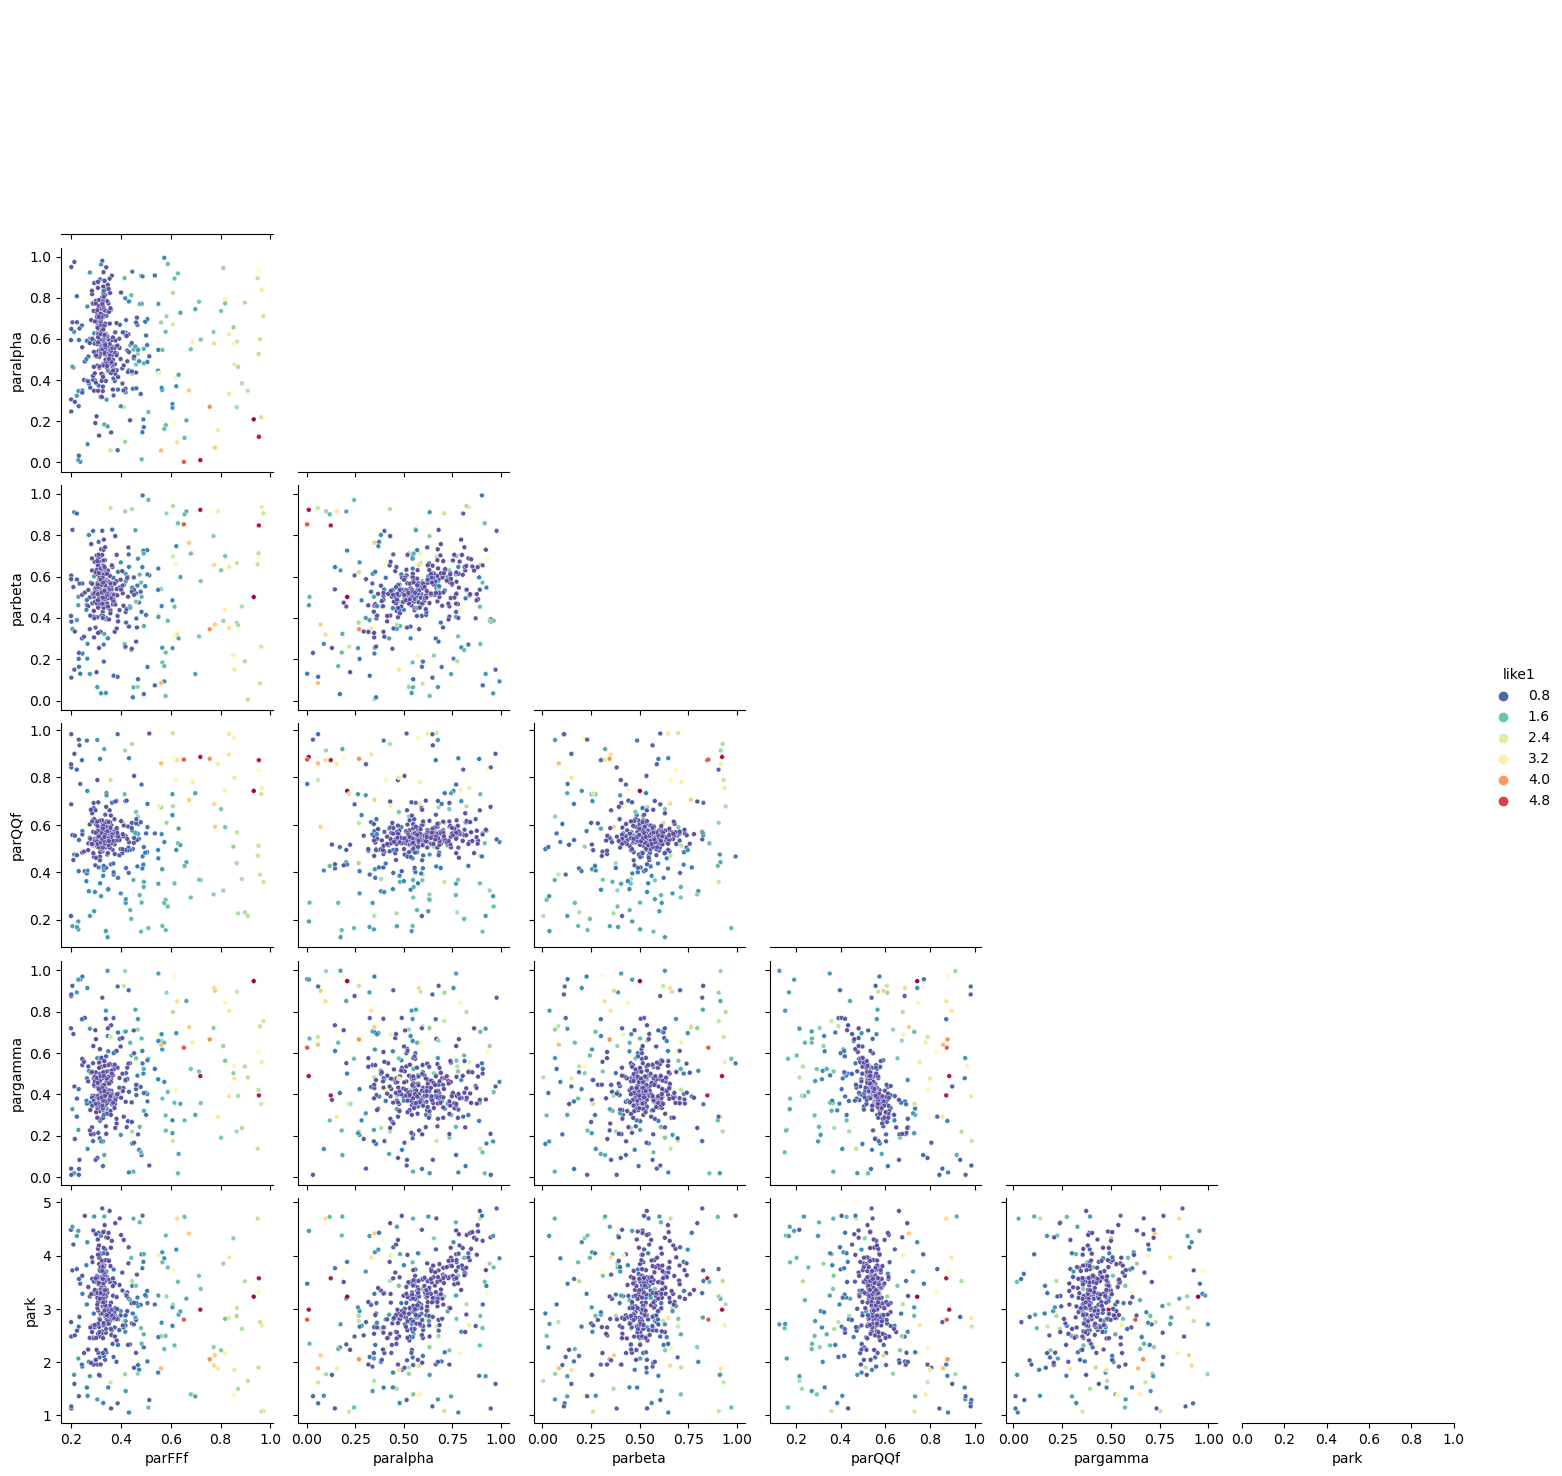

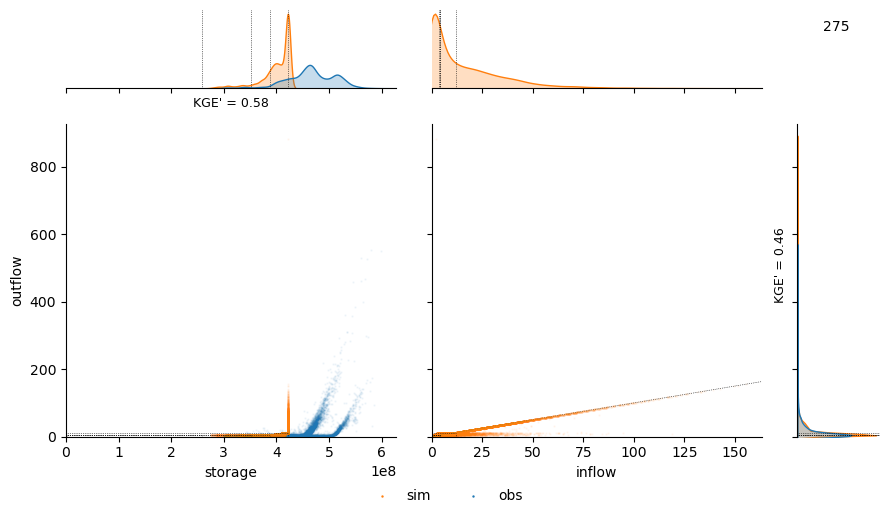

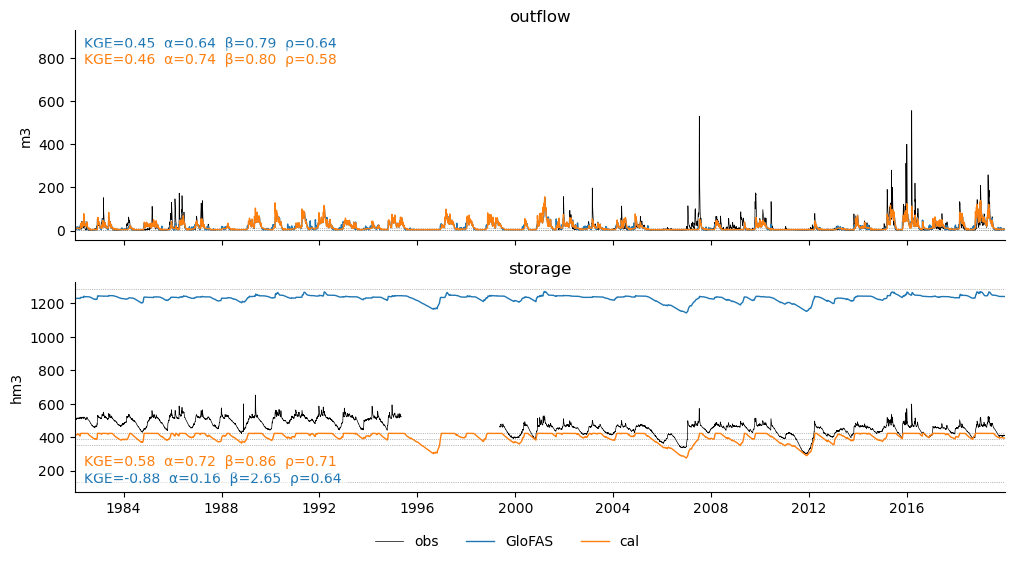

In [9]:
for ResID in tqdm([275]):#reservoirs.index):
    
    # file where the calibration results will be saved
    dbname = f'{path_out}/{ResID:03}_samples'
    if os.path.isfile(dbname + '.csv'):
        print(f'The file {dbname}.csv already exists.')
        continue
        
    ## TIME SERIES
    try:
        # observed time series
        obs = resops_ts[ResID][['storage', 'inflow', 'outflow']].copy()
        obs[obs < 0] = np.nan

        # define calibration period
        if obs.outflow.isnull().all():
            print(f'Reservoir {ResID} is missing outflow records')
            continue
        elif obs.storage.isnull().all():
            print(f'Reservoir {ResID} is missing storage records')
            continue
        else:
            start_obs = max([obs[var].first_valid_index() for var in ['storage', 'outflow']])
            end_obs = min([obs[var].last_valid_index() for var in ['storage', 'outflow']])
            cal_days = timedelta(days=np.floor((end_obs - start_obs).days * train_size))
            start_cal = end_obs - cal_days

        # define train and test time series
        x_train = glofas_ts[ResID].inflow[start_cal:end_obs]
        y_train = obs.loc[start_cal:end_obs, ['storage', 'outflow']]
        x_test = glofas_ts[ResID].inflow[start:start_cal]
        y_test = obs.loc[start_obs:start_cal, ['storage', 'outflow']]
        
    except:
        print(f'ERROR. The time series of reservoir {ResID} could not be set up')
        continue
        
    ## SET UP SPOTPY
    try:
        # extract GloFAS reservoir parameters
        Vc, Vtot, Qmin = reservoirs.loc[ResID, ['clim', 'CAP', 'minq']]
        Vtot *= 1e6
        Vc *= Vtot

        # initialize the calibration setup of the LISFLOOD reservoir routine
        setup = bivariate_6pars_1of(x_train, y_train.storage, y_train.outflow,
                                    Vc, Vtot, Qmin,
                                    KGEmod)

        # define the sampling method
        sceua = spotpy.algorithms.sceua(setup, dbname=dbname, dbformat='csv', save_sim=False)
    except:
        print(f'ERROR. The SpotPY set up of reservoir {ResID} could not be done')
        
    ## LAUNCH SAMPLING
    try:
        # start the sampler
        sceua.sample(max_iter, ngs=complexes, kstop=3, pcento=0.01, peps=0.1)
    except:
        print(f'ERROR. While sampling the reservoir {ResID}')
        continue

    ### ANALYSE RESULTS
    try:
        # read CSV of results
        results = pd.read_csv(f'{dbname}.csv')
        results.index.name = 'iteration'
        parcols = [col for col in results.columns if col.startswith('par')]
    except:
        print(f'ERROR while reading results form reservoir {ResID}')
        continue

        # # compute calibration KGE of each simulation
        # simulation = results.filter(regex='^simulation_').transpose()
        # simulation.index = pd.date_range(start_cal, end_obs, freq='D')
        # results['KGEcal'] = [KGEmod(y_train.outflow, simulation[i])[0] for i in simulation.columns]

    try:
        # compute validation KGE of each simulation and overwrite CSV file
        Vo = y_test.storage[0]
        #results['like_val'] = [1 - KGEmod(y_test.outflow, setup.simulation(results.loc[i, parcols], x_test, Vo))[0] for i in tqdm(results.index)]
        results['like_val'] = np.nan
        for i in tqdm(results.index):
            Q_sim, V_sim = setup.simulation(results.loc[i, parcols], x_test, Vo)
            results.loc[i, 'like_val'] = np.sqrt(np.sum([(1 - KGEmod(y_test.outflow, Q_sim)[0])**2, (1 - KGEmod(y_test.storage, V_sim)[0])**2]))
        results.to_csv(f'{dbname}.csv', index=False)
    except:
        print(f'ERROR while computing KGE for the validation period in reservoir {ResID}')

    try:
        # select optimal parameters
        best_iter = results.like1.idxmin()
        parvalues = {col[3:]: float(results.loc[best_iter, col]) for col in parcols}

        # export optimal parameters
        with open(f'{path_out}/{ResID:03}_optimal_parameters.yml', 'w') as file:
            yaml.dump(parvalues, file)
            
        # plot pairplot of the likelihood
        sns.pairplot(results, vars=parcols, corner=True, hue='like1', palette='Spectral_r', plot_kws={'s': 12})
        plt.savefig(path_out / f'{ResID:03}_pairplot.jpg', dpi=300, bbox_inches='tight')
    except:
        print(f'ERROR while searching for optimal parameters in reservoir {ResID}')
        continue

    try:

        # # declare the reservoir with the optimal parameters
        # Vn, Vf = [parvalues[var] * Vtot for var in ['FFn', 'FFf']]
        # Vn_adj = Vn + parvalues['alpha'] * (Vf - Vn)
        # Qn, Qf = [setup.inflow.quantile(parvalues[var]) for var in ['QQn', 'QQf']]
        # k = parvalues['k']
        # res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qf)
        
        # declare the reservoir with the optimal parameters
        Vf = parvalues['FFf'] * Vtot
        Vn = Vc + parvalues['alpha'] * (Vf - Vc)
        Vn_adj = Vn + parvalues['beta'] * (Vf - Vn)
        Qf = setup.inflow.quantile(parvalues['QQf'])
        Qn = parvalues['gamma'] * Qf
        k = parvalues['k']
        res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qf)

        # simulate the whole period and analyse
        sim = res.simulate(glofas_ts[ResID].inflow[start_obs:end_obs], obs.storage[start_obs], k=k)
        res.scatter(sim, obs, norm=False, title=ResID, save=path_out / f'{ResID:03}_scatter.jpg')
        res.lineplot({'GloFAS': glofas_ts[ResID], 'cal': sim}, obs, save=path_out / f'{ResID:03}_lineplot.jpg')

    except:
        print(f'ERROR while simulating with optimal parameters in reservoir {ResID}')

In [17]:
setup.simulation(results.loc[0, parcols], x_test, Vo)

[date
 1982-01-02    1595.74
 1982-01-03      40.81
 1982-01-04      40.74
 1982-01-05      39.98
 1982-01-06      39.98
                ...   
 1993-05-24     134.32
 1993-05-25     138.71
 1993-05-26     137.49
 1993-05-27     133.58
 1993-05-28     132.13
 Name: outflow, Length: 4165, dtype: float64,
 date
 1982-01-02    620174684.0
 1982-01-03    618347622.9
 1982-01-04    616512666.1
 1982-01-05    614722704.3
 1982-01-06    612917907.6
                  ...     
 1993-05-24    620174684.0
 1993-05-25    620174684.0
 1993-05-26    620174684.0
 1993-05-27    620174684.0
 1993-05-28    620174684.0
 Name: storage, Length: 4165, dtype: float64]

In [18]:
y_test

,storage,outflow
date,,
1982-01-02,756334000.0,35.141
1982-01-03,754343000.0,32.168
1982-01-04,752552000.0,30.299
1982-01-05,751556000.0,28.600
1982-01-06,750760000.0,27.581
...,...,...
1993-05-24,795328000.0,56.361
1993-05-25,799904000.0,56.316
1993-05-26,801984000.0,56.163


In [19]:
for i in tqdm(results.index):
    Q_sim, V_sim = setup.simulation(results.loc[i, parcols], x_test, Vo)
    np.sqrt(np.sum([(1 - KGEmod(y_test.outflow, Q_sim)[0])**2, (1 - KGEmod(y_test.storage, V_sim)[0])**2]))

  0%|          | 0/406 [00:00<?, ?it/s]

0.8440746848948831

In [13]:
    [1 - KGEmod(y_test.outflow, setup.simulation(results.loc[i, parcols], x_test, Vo))[0] for i in tqdm(results.index)]

  0%|          | 0/406 [00:00<?, ?it/s]

TypeError: cannot concatenate object of type '<class 'list'>'; only Series and DataFrame objs are valid

In [ ]:
aux = results.sort_values('like1', ascending=False)
x = np.arange(aux.shape[0])

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, 1 - aux.like1, label='cal')
ax.plot(x, 1 - aux.like_val, label='val')
ax.axvline(aux.index.get_loc(best_iter), c='k', lw=.5, ls=':')
ax.set(xlabel='iterations',
       xlim=(0, results.shape[0]),
       ylabel='KGE',
       ylim=(None, 1.02))
ax.legend(frameon=False);

## Results

In [ ]:
pars = {}
for ResID in tqdm(reservoirs.index):
    try:
        file = path_out / f'{ResID:03}_optimal_parameters.yml'
        with open(file, 'r') as f:
            pars[ResID] = yaml.load(f, Loader=yaml.FullLoader)
    except:
        print(f'The file {file} was not found')

In [ ]:
    pars

In [ ]:
for file in path_out.glob('*_optimal_parameters.yml'):
    print(file)
    break

In [ ]:
    with open(file, 'r') as f:
        data = yaml.load(f, Loader=yaml.FullLoader)

In [ ]:
    data

In [ ]:
    str(file).split('\')